In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
!pip install nltk
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

# Is the Sentiment in Reviews a Viable Predictor for the Average Rating of Products?

The goal of this analysis is to assess whether the sentiment noted in reviews of products with at least a certain minimum number of reviews is a viable predictor of the average rating of those products. If this is the case, can the sentiment in reviews of samples (chosen in a specific manner) of the dataset serve as viable estimators of the average rating of the products.

# Reviews Dataset Analysis

In [2]:
df_revs = pd.read_csv('vg_ratings.csv')
display(df_revs.shape)
df_revs.head()

(332645, 9)

,asin,overall,reviewerID,reviewerName,reviewText,summary,vote,count,avg_rating_unf
0,0700026398,1.0,A1NQ759X8WPIVV,Lynn,"I'm sure I would love the game, if I could pla...",Requires steam,0,5,3.2
1,0700026398,4.0,A2RGUDIF7VB7JZ,Johnathan Scott,Good game,Four Stars,0,5,3.2
2,0700026398,4.0,A2FTI5YE727I78,CubOfJudahsLion,This installment introduces some unusual eleme...,I like him having some motivation to pursue a ...,0,5,3.2
3,0700026398,2.0,A2IPY9UTB8JEU5,Emelinda Willis,This game requires that you open an online acc...,Requires constant online access. This is only ...,0,5,3.2
4,0700026398,5.0,AK9YPIL2TWL24,David Neil,great game! go agent 47!,Five Stars,0,5,3.2


## Determine Frequency Distribution of 1,2,3,4 and 5 Star Reviews

In [3]:
df_revs['vote'].value_counts()

0      295026
2       13981
3        6797
4        3864
5        2588
        ...  
138         1
182         1
166         1
500         1
282         1
Name: vote, Length: 264, dtype: int64

In [4]:
count_ratings_df = df_revs.groupby(['asin', 'overall']).count()[['count']].reset_index()
count_ratings_df

,asin,overall,count
0,0700026398,1.0,1
1,0700026398,2.0,1
2,0700026398,4.0,2
3,0700026398,5.0,1
4,0700026657,2.0,1
...,...,...,...
50910,B01HIZF7XE,5.0,25
50911,B01HIZGKOE,2.0,2
50912,B01HIZGKOE,3.0,1
50913,B01HIZGKOE,4.0,1


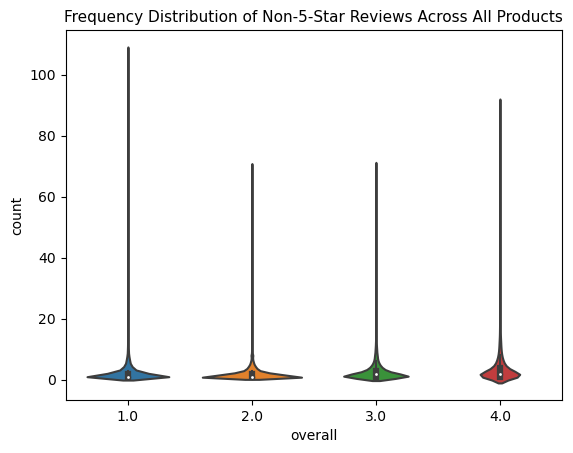

In [5]:
# Did not plot 
sns.violinplot(data = count_ratings_df[count_ratings_df['overall'] != 5], x = 'overall', y = 'count')
plt.title('Frequency Distribution of Non-5-Star Reviews Across All Products', fontsize = 11);

Did not plot the distribution for the counts of 5 star reviews alongside the counts of 1,2,3, and 4 star reviews because there is a much larger distribution for the 5 star reviews. The plot does illustrate how the distribution of the counts of non-5 star review are comparable. 

In [6]:
df_neat_ratings_counts = pd.pivot_table(data = count_ratings_df, index = 'asin', columns = 'overall', values = 'count')
df_neat_ratings_counts.fillna(0, inplace = True)
df_neat_ratings_counts.head()

overall,1.0,2.0,3.0,4.0,5.0
asin,,,,,
0700026398,1.0,1.0,0.0,2.0,1.0
0700026657,0.0,1.0,1.0,3.0,5.0
0700099867,6.0,2.0,3.0,4.0,7.0
0804161380,0.0,1.0,0.0,6.0,41.0
3828770193,0.0,0.0,1.0,2.0,2.0


In [7]:
# Run below only once since will overwrite num_review column 
df_neat_ratings_counts['num_reviews'] = df_neat_ratings_counts.sum(axis = 1)
display('Number of Products: ' + str(df_neat_ratings_counts.shape[0]))
df_neat_ratings_counts

'Number of Products: 17099'

overall,1.0,2.0,3.0,4.0,5.0,num_reviews
asin,,,,,,
0700026398,1.0,1.0,0.0,2.0,1.0,5.0
0700026657,0.0,1.0,1.0,3.0,5.0,10.0
0700099867,6.0,2.0,3.0,4.0,7.0,22.0
0804161380,0.0,1.0,0.0,6.0,41.0,48.0
3828770193,0.0,0.0,1.0,2.0,2.0,5.0
...,...,...,...,...,...,...
B01HFRICLE,0.0,0.0,2.0,4.0,7.0,13.0
B01HGPUTCA,0.0,0.0,0.0,2.0,3.0,5.0
B01HH6JEOC,0.0,0.0,3.0,1.0,3.0,7.0


In [8]:
# Displaying general statistics for frequency distributions of all review types and for number of reviews per product
df_neat_ratings_counts.describe()

overall,1.0,2.0,3.0,4.0,5.0,num_reviews
count,17099.000000,17099.000000,17099.000000,17099.000000,17099.000000,17099.000000
mean,0.889058,0.708813,1.636236,3.209895,13.010059,19.454062
std,2.253402,1.740458,3.292656,6.059071,27.583163,37.611545
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,0.000000,0.000000,0.000000,0.000000,3.000000,5.000000
50%,0.000000,0.000000,1.000000,1.000000,5.000000,8.000000
75%,1.000000,1.000000,2.000000,3.000000,12.000000,18.000000
max,108.000000,70.000000,70.000000,90.000000,513.000000,649.000000


### Distribution of Number of Reviews

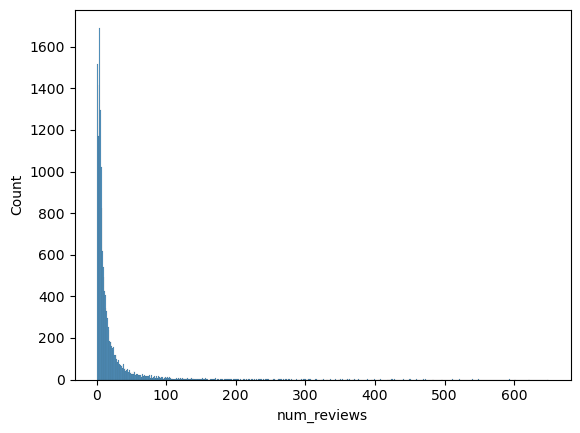

In [9]:
sns.histplot(data = df_neat_ratings_counts, x = 'num_reviews');

### Using 25th Percentile of the Number of Reviews as Cutoff for Products kept in Sentiment Analysis


In [10]:
perc = np.percentile(df_neat_ratings_counts['num_reviews'], 25)
perc

5.0

In [11]:
df_des_revs = df_neat_ratings_counts[df_neat_ratings_counts['num_reviews'] >= perc]
display(df_des_revs.shape)
df_des_revs.head()

(12992, 6)

overall,1.0,2.0,3.0,4.0,5.0,num_reviews
asin,,,,,,
0700026398,1.0,1.0,0.0,2.0,1.0,5.0
0700026657,0.0,1.0,1.0,3.0,5.0,10.0
0700099867,6.0,2.0,3.0,4.0,7.0,22.0
0804161380,0.0,1.0,0.0,6.0,41.0,48.0
3828770193,0.0,0.0,1.0,2.0,2.0,5.0


In [12]:
display('Number of Products: ' + str(df_neat_ratings_counts.shape[0]))
display('New Number of Products who meet desired cutoff of at least 5 reviews: ' + str(df_des_revs.shape[0]))

'Number of Products: 17099'

'New Number of Products who meet desired cutoff of at least 5 reviews: 12992'

## Sentiment Analysis on Reviews of Products who meet minimum Number of Reviews Threshold

In [13]:
# Isolate desired portion of the dataset, keeping products with at least 5 (25th percentile) reviews 
df_iso_25 = df_revs[df_revs['count'] >= perc]
display(df_iso_25.shape)
df_iso_25.head()

(321066, 9)

,asin,overall,reviewerID,reviewerName,reviewText,summary,vote,count,avg_rating_unf
0,0700026398,1.0,A1NQ759X8WPIVV,Lynn,"I'm sure I would love the game, if I could pla...",Requires steam,0,5,3.2
1,0700026398,4.0,A2RGUDIF7VB7JZ,Johnathan Scott,Good game,Four Stars,0,5,3.2
2,0700026398,4.0,A2FTI5YE727I78,CubOfJudahsLion,This installment introduces some unusual eleme...,I like him having some motivation to pursue a ...,0,5,3.2
3,0700026398,2.0,A2IPY9UTB8JEU5,Emelinda Willis,This game requires that you open an online acc...,Requires constant online access. This is only ...,0,5,3.2
4,0700026398,5.0,AK9YPIL2TWL24,David Neil,great game! go agent 47!,Five Stars,0,5,3.2


# Isolate desired portion of the dataset, only obtaining reviews of products with more than or equal to 5, 5 star reviews
#iso_25th percentile
df_iso_25 = pd.merge(df_revs.set_index('asin'), df_des_revs['num_reviews'], left_index= True, right_index = True)
display(df_iso_25.shape)
df_iso_25.head()
# Used products 

## Checking to see how many NANs

In [14]:
df_iso_25.isna().sum()

asin                0
overall             0
reviewerID          0
reviewerName      163
reviewText        143
summary            86
vote                0
count               0
avg_rating_unf      0
dtype: int64

In [15]:
# Checking to see what is in the columns where reviewText is Nan
df_iso_25[df_iso_25['reviewText'].isna()]

,asin,overall,reviewerID,reviewerName,reviewText,summary,vote,count,avg_rating_unf
505,B000006RGR,5.0,A3N9BKUHN4B6J2,mohamedalkuwari,NaN,Five Stars,0,11,4.636364
522,B000006RGS,5.0,A3N9BKUHN4B6J2,mohamedalkuwari,NaN,Five Stars,0,20,4.450000
3031,B00001ZT9E,5.0,A3N9BKUHN4B6J2,mohamedalkuwari,NaN,Five Stars,0,7,4.285714
3841,B00002R28F,5.0,A2XIJG9EJFW1U7,Mahmood,NaN,Five Stars,0,12,4.500000
6252,B000031KJM,5.0,A1G2R5DGP0545K,NickStRRR,NaN,Five Stars,0,30,4.733333
...,...,...,...,...,...,...,...,...,...
320363,B01AC3ZD06,5.0,A3SBULFV1ZKFYU,pedro martinez,NaN,Five Stars,0,87,4.919540
323355,B01CEFXCE4,1.0,A1230IVR534KIH,Nathan,NaN,Instructions from website are in chinease crap,0,12,3.416667
323786,B01CKGI4RM,5.0,A3SBULFV1ZKFYU,pedro martinez,NaN,Five Stars,0,60,4.400000
329160,B01GKGVI8U,5.0,A1BNU92K69LUMC,valone,NaN,Five Stars,0,171,4.567251


In [16]:
# Dont know how there can be a summary if the reviewText is empty so just going to drop these reviews later on
df_iso_25[df_iso_25['reviewText'].isna()]['summary'].value_counts()

Five Stars                                            121
Four Stars                                              4
Three Stars                                             4
Unhappy.                                                1
One Star                                                1
Could of been alittle longer but still fun to play      1
Cool                                                    1
Good replacement that is all.                           1
Very nice                                               1
Awesome.                                                1
Great skin for the price                                1
Instructions from website are in chinease crap          1
Name: summary, dtype: int64

In [17]:
df_iso_25[df_iso_25['summary'].isna()]

,asin,overall,reviewerID,reviewerName,reviewText,summary,vote,count,avg_rating_unf
1295,B00000I1C1,5.0,A38D4I8SWY6MU1,Marilyn Tyree,Awesome,NaN,0,17,4.764706
6605,B000035XLE,2.0,A21D3NZNORHY74,Gerson,The supposed included poster was missing bumme...,NaN,0,13,4.307692
10108,B00004TN8R,5.0,A38D4I8SWY6MU1,Marilyn Tyree,Awesome,NaN,0,13,4.307692
12428,B00005A4X6,5.0,A2LPD0V7XIKIRL,Xander,Really good game which I didn't expect because...,NaN,0,15,4.133333
13195,B00005CDR8,5.0,A1OLI6ZBZWDSBO,WAEL M BEDEER,very good :) thanks >,NaN,0,33,4.666667
...,...,...,...,...,...,...,...,...,...
325226,B01DPUVMFS,5.0,A3R7ZCCLNJMBOI,jim burton,Good,NaN,0,25,3.920000
325556,B01E38YIJI,5.0,A3UGILCWBKAR1H,Agent Cooper,Love it,NaN,0,26,3.807692
325731,B01EAG0VCG,5.0,A34G07PW0P6G8V,Edgar,Perfect!,NaN,0,15,4.933333
326694,B01EZAA2ZI,5.0,A1DQJ26EQ1XNP0,RCN001,MODERN WARFARE REMASTERED. ALL I HAVE TO SAY!,NaN,0,123,3.731707


## Testing nltk (Package for Sentiment Analysis)

In [18]:
# Set up for Sentiment Scores
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jovyan/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [19]:
rng_row = df_iso_25.sample(1)
display(rng_row)
ex_text = ''.join(rng_row['reviewText'].values)
ex_text

,asin,overall,reviewerID,reviewerName,reviewText,summary,vote,count,avg_rating_unf
122572,B002EE5SAC,4.0,A32M8IN9X7F8GB,Phantos,Although this isn't the best fighting game in ...,Fun with cool characters,0,34,4.823529


"Although this isn't the best fighting game in the world, there are lots of characters here and it is a lot of fun. It works with the Wiimote but I got some arcade-style pads for it and it's more fun to play that way. You can also use Gamecube controllers with this although the arcade sticks are still easier and more fun. This may be the best fighting game for the Wii."

In [20]:
# Empty Strings have a compound score of 0, so fine to keep empty strings and should replace NANs in summary as empty strings
sid.polarity_scores('')

{'neg': 0.0, 'neu': 0.0, 'pos': 0.0, 'compound': 0.0}

In [21]:
sid.polarity_scores('good game')

{'neg': 0.0, 'neu': 0.256, 'pos': 0.744, 'compound': 0.4404}

In [22]:
sid.polarity_scores('good game!')

{'neg': 0.0, 'neu': 0.239, 'pos': 0.761, 'compound': 0.4926}

In [23]:
sid.polarity_scores('GOOD GAME!')

{'neg': 0.0, 'neu': 0.239, 'pos': 0.761, 'compound': 0.4926}

In [24]:
sid.polarity_scores(':)')

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4588}

In [25]:
sid.polarity_scores(ex_text)

{'neg': 0.075, 'neu': 0.676, 'pos': 0.249, 'compound': 0.9406}

**Findings:**
1. Empty Strings have a compound score of 0, so fine to keep empty strings and should replace NANs in summary as empty strings
2. NTLK takes into account punctuation, and emojis, but surprised capitalization of words is not factored in  
4. Large amount of text inflates neutral score and corresponding compound score.
    Thus, I need to split reviews who contain multiple sentences into separate sentences and compute average sentiment for all of those sentences. This average sentiment value will be the corresponding sentiment score for that review
5. Quickness of shipping is factored into review as well

## Dealing with NANs in the reviewText & summary columns; Drop Reviewer Identification columns

In [26]:
df_iso_25.dropna(subset = ['reviewText'], inplace = True)
df_iso_25['summary'].fillna('', inplace = True)
df_iso_25.drop(columns = ['reviewerID', 'reviewerName'], inplace = True)
df_iso_25.isna().sum()

/tmp/ipykernel_3329/2966590079.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iso_25.dropna(subset = ['reviewText'], inplace = True)
/tmp/ipykernel_3329/2966590079.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iso_25['summary'].fillna('', inplace = True)
/tmp/ipykernel_3329/2966590079.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_iso_25.drop(columns = ['reviewerID', 'reviewerName'], inplace = True)


asin              0
overall           0
reviewText        0
summary           0
vote              0
count             0
avg_rating_unf    0
dtype: int64

In [27]:
# Testing package function which splits reviews into multiple sentences  
nltk.sent_tokenize(df_iso_25.iloc[3]['reviewText'])

['This game requires that you open an online account to play the game.',
 'A constant online source is required.',
 'Gave the game away.']

## Computing Polarity Scores for All Reviews of Chosen Products

In [28]:
def sent_hand_mult(x):
    all_scores = [sid.polarity_scores(str(uno)) for uno in x]
    neg_mean = np.mean([sent['neg'] for sent in all_scores])
    neu_mean = np.mean([sent['neu'] for sent in all_scores])
    pos_mean = np.mean([sent['pos'] for sent in all_scores])
    cmp_mean = np.mean([sent['compound'] for sent in all_scores])
    return {'neg_mean' : neg_mean, 'neu_mean' : neu_mean, 'pos_mean' : pos_mean, 'cmp_mean' : cmp_mean}
    
                       
    

In [29]:
atemp = df_iso_25['reviewText'].apply(lambda x: nltk.sent_tokenize(x)).to_frame()

In [30]:
atemp['Sem_Scores'] = atemp['reviewText'].apply(sent_hand_mult)

In [31]:
atemp['cmp_scores'] = atemp['Sem_Scores'].apply(lambda x: x['cmp_mean'])

In [32]:
atemp['neg_scores'] = atemp['Sem_Scores'].apply(lambda x: x['neg_mean'])
atemp['neu_scores'] = atemp['Sem_Scores'].apply(lambda x: x['neu_mean'])
atemp['pos_scores'] = atemp['Sem_Scores'].apply(lambda x: x['pos_mean'])

In [33]:
atemp.reset_index(inplace = True)
df_iso_25.reset_index(inplace = True)

In [34]:
atemp.head()

,index,reviewText,Sem_Scores,cmp_scores,neg_scores,neu_scores,pos_scores
0,0,"[I'm sure I would love the game, if I could pl...","{'neg_mean': 0.07844444444444444, 'neu_mean': ...",0.131311,0.078444,0.778889,0.142667
1,1,[Good game],"{'neg_mean': 0.0, 'neu_mean': 0.256, 'pos_mean...",0.440400,0.000000,0.256000,0.744000
2,2,[This installment introduces some unusual elem...,"{'neg_mean': 0.1554, 'neu_mean': 0.748, 'pos_m...",-0.169680,0.155400,0.748000,0.096400
3,3,[This game requires that you open an online ac...,"{'neg_mean': 0.0, 'neu_mean': 0.94433333333333...",0.113333,0.000000,0.944333,0.055667
4,4,"[great game!, go agent 47!]","{'neg_mean': 0.0, 'neu_mean': 0.5925, 'pos_mea...",0.329400,0.000000,0.592500,0.407500


In [35]:
# Range of cmp scores from -1 to 1
atemp['cmp_scores'].describe()

count    320923.000000
mean          0.343672
std           0.307673
min          -0.998600
25%           0.128297
50%           0.365500
75%           0.585900
max           0.999200
Name: cmp_scores, dtype: float64

In [36]:
df_iso_25 = pd.concat([df_iso_25, atemp[['Sem_Scores', 'cmp_scores', 'neg_scores', 'neu_scores', 'pos_scores']]], axis = 1).drop(columns = 'index')
display(df_iso_25.shape)
df_iso_25.head()

(320923, 12)

,asin,overall,reviewText,summary,vote,count,avg_rating_unf,Sem_Scores,cmp_scores,neg_scores,neu_scores,pos_scores
0,0700026398,1.0,"I'm sure I would love the game, if I could pla...",Requires steam,0,5,3.2,"{'neg_mean': 0.07844444444444444, 'neu_mean': ...",0.131311,0.078444,0.778889,0.142667
1,0700026398,4.0,Good game,Four Stars,0,5,3.2,"{'neg_mean': 0.0, 'neu_mean': 0.256, 'pos_mean...",0.440400,0.000000,0.256000,0.744000
2,0700026398,4.0,This installment introduces some unusual eleme...,I like him having some motivation to pursue a ...,0,5,3.2,"{'neg_mean': 0.1554, 'neu_mean': 0.748, 'pos_m...",-0.169680,0.155400,0.748000,0.096400
3,0700026398,2.0,This game requires that you open an online acc...,Requires constant online access. This is only ...,0,5,3.2,"{'neg_mean': 0.0, 'neu_mean': 0.94433333333333...",0.113333,0.000000,0.944333,0.055667
4,0700026398,5.0,great game! go agent 47!,Five Stars,0,5,3.2,"{'neg_mean': 0.0, 'neu_mean': 0.5925, 'pos_mea...",0.329400,0.000000,0.592500,0.407500


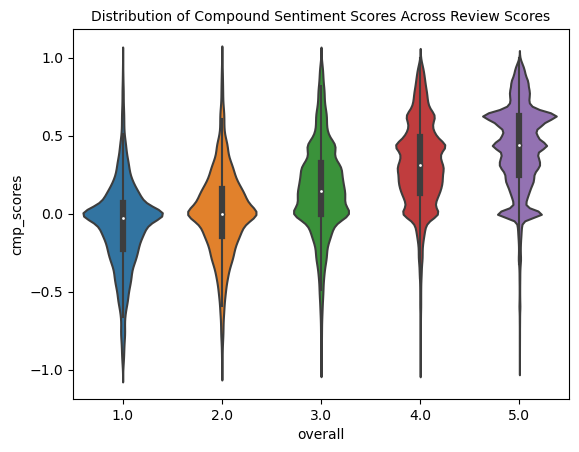

In [37]:
sns.violinplot(data = df_iso_25, y = 'cmp_scores', x = 'overall');
plt.title('Distribution of Compound Sentiment Scores Across Review Scores', fontsize = 10);

**Clear variation in the compound sentiment scores across 1,2,3,4,5 star reviews implying the average compound sentiment score for a product should be a good predictor for the product's average rating** 

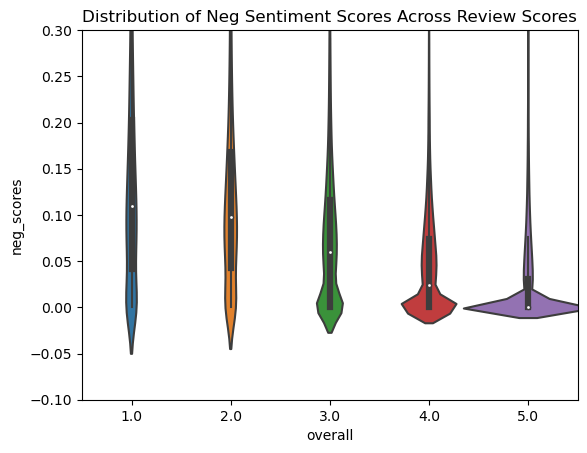

In [38]:
ax = sns.violinplot(data = df_iso_25, y = 'neg_scores', x = 'overall', width = 1.3);
ax.set(ylim=(-0.1, 0.3))
plt.title('Distribution of Neg Sentiment Scores Across Review Scores');

**Hard to tell, but there is good variation in the negative sentiment scores across 1,2,3,4,5 star reviews implying the average negative sentiment score for a product may be a decent predictor for the product's average rating. Attempting to give a zoomed-in view of the violinplot.** 

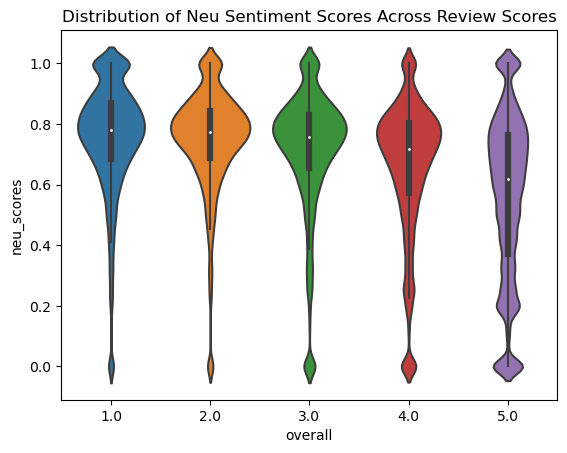

In [39]:
sns.violinplot(data = df_iso_25, y = 'neu_scores', x = 'overall');
plt.title('Distribution of Neu Sentiment Scores Across Review Scores');

**Not great variation in the neutral sentiment scores across 1,2,3,4,5 star reviews implying the average neutral sentiment score for a product may not be a good predictor for the product's average rating** 

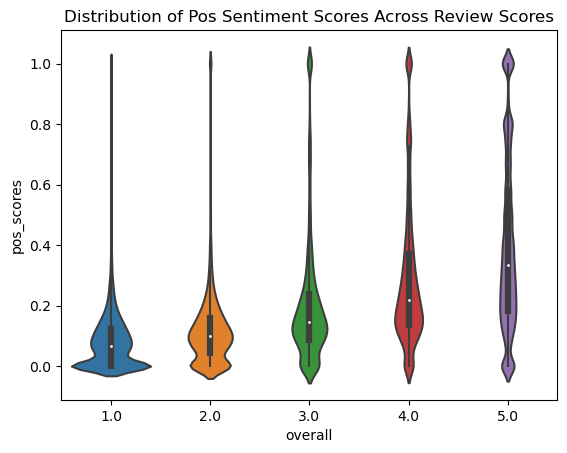

In [40]:
sns.violinplot(data = df_iso_25, y = 'pos_scores', x = 'overall');
plt.title('Distribution of Pos Sentiment Scores Across Review Scores');

**Good variation in the positive sentiment scores across 1,2,3,4,5 star reviews implying the average positive sentiment score for a product may be a good predictor for the product's average rating.** 

In [41]:
df_iso_25.corr()

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores
overall,1.000000,-0.046292,0.059350,0.366315,0.446084,-0.365749,-0.239580,0.337308
vote,-0.046292,1.000000,-0.004391,-0.029636,-0.049868,0.020099,0.064048,-0.065081
count,0.059350,-0.004391,1.000000,0.162033,0.003549,-0.012655,-0.019385,0.021114
avg_rating_unf,0.366315,-0.029636,0.162033,1.000000,0.178020,-0.143911,-0.096454,0.133932
cmp_scores,0.446084,-0.049868,0.003549,0.178020,1.000000,-0.575941,-0.461497,0.638324
neg_scores,-0.365749,0.020099,-0.012655,-0.143911,-0.575941,1.000000,0.028553,-0.340591
neu_scores,-0.239580,0.064048,-0.019385,-0.096454,-0.461497,0.028553,1.000000,-0.920133
pos_scores,0.337308,-0.065081,0.021114,0.133932,0.638324,-0.340591,-0.920133,1.000000


In [42]:
# Correlation with mean of each respective product's reviews sentiment scores
df_iso_25.groupby('asin').mean().corr()

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores
overall,1.000000,-0.122230,0.094482,0.999937,0.565701,-0.475573,-0.298069,0.413724
vote,-0.122230,1.000000,0.001668,-0.122244,-0.137482,0.063746,0.180929,-0.187075
count,0.094482,0.001668,1.000000,0.094523,0.014561,-0.015366,-0.029945,0.031025
avg_rating_unf,0.999937,-0.122244,0.094523,1.000000,0.565603,-0.475265,-0.298279,0.413821
cmp_scores,0.565701,-0.137482,0.014561,0.565603,1.000000,-0.630402,-0.526161,0.687622
neg_scores,-0.475573,0.063746,-0.015366,-0.475265,-0.630402,1.000000,0.102687,-0.385825
neu_scores,-0.298069,0.180929,-0.029945,-0.298279,-0.526161,0.102687,1.000000,-0.938676
pos_scores,0.413724,-0.187075,0.031025,0.413821,0.687622,-0.385825,-0.938676,1.000000


In this step, I am taking the groupby and mean to see the correlation of the mean sentiment scores from all reviews of each product with the product's average rating. As expected, average rating has a higher correlation of 0.57 with the mean compound sentiment scores than for each product's individual review's sentiment scores.

***The next few phases of the analysis are focused on using various hypotheses to generate various samples of the dataset and see if their respective mean compound sentiment scores' correlation with the average product rating is comparable to the correlation value noted for the entire dataset.*** 

## Is looking at only 5 star reviews or non 5 star reviews sufficient to predict product's average rating?

In [43]:
# Looking purely at the non 5 star reviews of those products
df_iso_25_nrevs5 = df_iso_25[df_iso_25['overall'] != 5.0]
display(df_iso_25_nrevs5.shape)
df_iso_25_nrevs5

(105531, 12)

,asin,overall,reviewText,summary,vote,count,avg_rating_unf,Sem_Scores,cmp_scores,neg_scores,neu_scores,pos_scores
0,0700026398,1.0,"I'm sure I would love the game, if I could pla...",Requires steam,0,5,3.200000,"{'neg_mean': 0.07844444444444444, 'neu_mean': ...",0.131311,0.078444,0.778889,0.142667
1,0700026398,4.0,Good game,Four Stars,0,5,3.200000,"{'neg_mean': 0.0, 'neu_mean': 0.256, 'pos_mean...",0.440400,0.000000,0.256000,0.744000
2,0700026398,4.0,This installment introduces some unusual eleme...,I like him having some motivation to pursue a ...,0,5,3.200000,"{'neg_mean': 0.1554, 'neu_mean': 0.748, 'pos_m...",-0.169680,0.155400,0.748000,0.096400
3,0700026398,2.0,This game requires that you open an online acc...,Requires constant online access. This is only ...,0,5,3.200000,"{'neg_mean': 0.0, 'neu_mean': 0.94433333333333...",0.113333,0.000000,0.944333,0.055667
6,0700026657,3.0,ok game.,Three Stars,0,10,4.200000,"{'neg_mean': 0.0, 'neu_mean': 0.312, 'pos_mean...",0.296000,0.000000,0.312000,0.688000
...,...,...,...,...,...,...,...,...,...,...,...,...
320916,B01HIZF7XE,4.0,A little disappointed that Bioshock 1 doesn't ...,"Great Graphics, Crappy Sound",4,35,4.657143,"{'neg_mean': 0.076, 'neu_mean': 0.643666666666...",0.480500,0.076000,0.643667,0.280667
320917,B01HIZGKOE,4.0,Good game,Four Stars,0,6,3.500000,"{'neg_mean': 0.0, 'neu_mean': 0.256, 'pos_mean...",0.440400,0.000000,0.256000,0.744000
320919,B01HIZGKOE,3.0,"Can't expect too much from this game, the WW2 ...","the WW2 stuff is pretty good, fun missions",2,6,3.500000,"{'neg_mean': 0.09, 'neu_mean': 0.638, 'pos_mea...",0.743000,0.090000,0.638000,0.272000
320920,B01HIZGKOE,2.0,It's ok. Still cant use PS4 Hotas joy stick.,Still cant use PS4 Hotas joy stick.,0,6,3.500000,"{'neg_mean': 0.0, 'neu_mean': 0.46199999999999...",0.440950,0.000000,0.462000,0.538000


In [44]:
df_iso_25_revs5 = df_iso_25[df_iso_25['overall'] == 5.0]
display(df_iso_25_revs5.shape)
df_iso_25_revs5.head()

(215392, 12)

,asin,overall,reviewText,summary,vote,count,avg_rating_unf,Sem_Scores,cmp_scores,neg_scores,neu_scores,pos_scores
4,0700026398,5.0,great game! go agent 47!,Five Stars,0,5,3.2,"{'neg_mean': 0.0, 'neu_mean': 0.5925, 'pos_mea...",0.329400,0.000000,0.592500,0.407500
5,0700026657,5.0,"This game is a bit hard to get the hang of, bu...",but when you do it's great.,0,10,4.2,"{'neg_mean': 0.058, 'neu_mean': 0.671, 'pos_me...",0.754300,0.058000,0.671000,0.271000
8,0700026657,5.0,"great game, I love it and have played it since...",love this game,0,10,4.2,"{'neg_mean': 0.0, 'neu_mean': 0.428, 'pos_mean...",0.893400,0.000000,0.428000,0.572000
10,0700026657,5.0,I bought this game thinking it would be pretty...,A very good game balance of skill with depth o...,0,10,4.2,"{'neg_mean': 0.12616666666666668, 'neu_mean': ...",0.096050,0.126167,0.755167,0.118833
11,0700026657,5.0,I have played the old anno 1701 AND 1503. thi...,Anno 2070 more like anno 1701,0,10,4.2,"{'neg_mean': 0.009111111111111111, 'neu_mean':...",0.223867,0.009111,0.897000,0.093889


In [45]:
df_iso_25_revs5.corr().fillna(0)

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores
overall,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vote,0.0,1.000000,-0.008092,-0.007746,-0.045497,0.020903,0.062614,-0.063090
count,0.0,-0.008092,1.000000,0.119785,-0.022315,0.004364,-0.003958,0.002114
avg_rating_unf,0.0,-0.007746,0.119785,1.000000,0.021819,-0.023242,0.001796,0.002610
cmp_scores,0.0,-0.045497,-0.022315,0.021819,1.000000,-0.472637,-0.479402,0.601676
neg_scores,0.0,0.020903,0.004364,-0.023242,-0.472637,1.000000,0.059392,-0.284119
neu_scores,0.0,0.062614,-0.003958,0.001796,-0.479402,0.059392,1.000000,-0.939261
pos_scores,0.0,-0.063090,0.002114,0.002610,0.601676,-0.284119,-0.939261,1.000000


In [46]:
df_iso_25_revs5.groupby('asin').mean().corr().fillna(0)

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores
overall,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
vote,0.0,1.000000,-0.002380,-0.027433,-0.098201,0.050158,0.141887,-0.144529
count,0.0,-0.002380,1.000000,0.088150,-0.023688,0.017356,-0.000536,-0.003513
avg_rating_unf,0.0,-0.027433,0.088150,1.000000,0.048739,-0.015799,0.009445,-0.007513
cmp_scores,0.0,-0.098201,-0.023688,0.048739,1.000000,-0.493213,-0.514828,0.617643
neg_scores,0.0,0.050158,0.017356,-0.015799,-0.493213,1.000000,0.140663,-0.332480
neu_scores,0.0,0.141887,-0.000536,0.009445,-0.514828,0.140663,1.000000,-0.952575
pos_scores,0.0,-0.144529,-0.003513,-0.007513,0.617643,-0.332480,-0.952575,1.000000


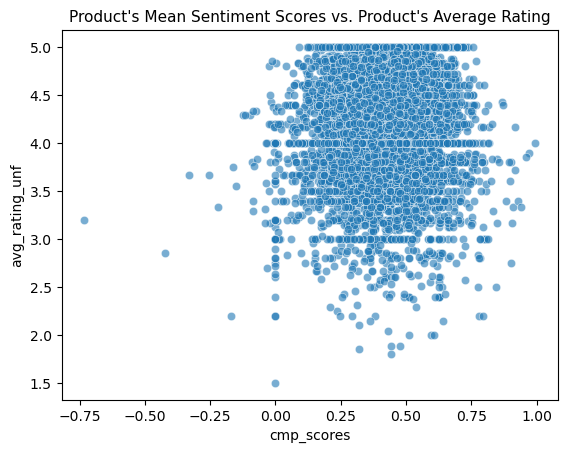

In [47]:
sns.scatterplot(data = df_iso_25_revs5.groupby('asin').mean(), x ='cmp_scores', y = 'avg_rating_unf', alpha = 0.6)
plt.title('Product\'s Mean Sentiment Scores vs. Product\'s Average Rating', fontsize = 11); 

No correlation of overall with other features since overall, which represents a review's rating, is 5 for all products. Also, after looking at the correlation of the mean average compound sentiment score from all reviews of a product with that product's average rating, it is clear from the correlation value of 0.05 that there is not enough inherent variation in the mean sentiment scores for the reviews of each product to match the entire range of average product ratings. ***This sample is also two-thirds of the entire dataset, so it shows the size of the sample does not matter as much as the quality of the sample.*** 

In [48]:
# Irrational to look only at the 5 star reviews to predict rating, much lower correlation value
df_iso_25_nrevs5.corr()

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores
overall,1.000000,-0.047870,0.021315,0.300556,0.461154,-0.329801,-0.181153,0.353114
vote,-0.047870,1.000000,0.007811,-0.034418,-0.034240,0.002808,0.053895,-0.052568
count,0.021315,0.007811,1.000000,0.209351,-0.018040,0.007344,-0.006152,0.001525
avg_rating_unf,0.300556,-0.034418,0.209351,1.000000,0.148897,-0.100654,-0.083233,0.133898
cmp_scores,0.461154,-0.034240,-0.018040,0.148897,1.000000,-0.614665,-0.296396,0.617125
neg_scores,-0.329801,0.002808,0.007344,-0.100654,-0.614665,1.000000,-0.193674,-0.331657
neu_scores,-0.181153,0.053895,-0.006152,-0.083233,-0.296396,-0.193674,1.000000,-0.839907
pos_scores,0.353114,-0.052568,0.001525,0.133898,0.617125,-0.331657,-0.839907,1.000000


In [49]:
# Non-5 star reviews have similar correlation when not averaged, but don't gain as much when averaged
df_iso_25_nrevs5.groupby('asin').mean().corr()

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores
overall,1.000000,-0.053718,0.046720,0.598810,0.492615,-0.349789,-0.201961,0.371397
vote,-0.053718,1.000000,0.015811,-0.086057,-0.061414,0.004708,0.104957,-0.101408
count,0.046720,0.015811,1.000000,0.126384,-0.011235,0.010289,-0.015412,0.008621
avg_rating_unf,0.598810,-0.086057,0.126384,1.000000,0.306612,-0.222861,-0.136380,0.243133
cmp_scores,0.492615,-0.061414,-0.011235,0.306612,1.000000,-0.606974,-0.354713,0.641865
neg_scores,-0.349789,0.004708,0.010289,-0.222861,-0.606974,1.000000,-0.164681,-0.324245
neu_scores,-0.201961,0.104957,-0.015412,-0.136380,-0.354713,-0.164681,1.000000,-0.864721
pos_scores,0.371397,-0.101408,0.008621,0.243133,0.641865,-0.324245,-0.864721,1.000000


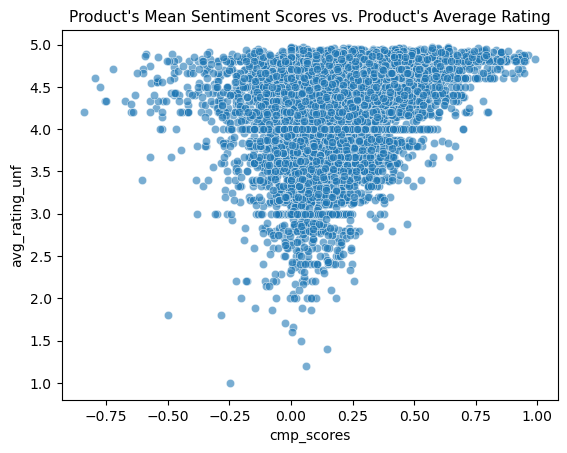

In [50]:
sns.scatterplot(data = df_iso_25_nrevs5.groupby('asin').mean(), x ='cmp_scores', y = 'avg_rating_unf', alpha = 0.6)
plt.title('Product\'s Mean Sentiment Scores vs. Product\'s Average Rating', fontsize = 11); 

After looking at the correlation of the mean average compound sentiment score from all reviews of a product with that product's average rating, it is clear from the correlation value of 0.30 that there is decent inherent variation in the mean sentiment scores for the reviews of each product to match the entire range of average product ratings. ***This sample is also one-third of the entire dataset, so it shows the size of the sample does not matter as much as the quality of the sample.*** 

## Sample Text from Non-5-Star Reviews and 5 Star Reviews

In [51]:
df_iso_25_nrevs5['reviewText'].value_counts()

good                                                                                                                                                                                                                                               590
ok                                                                                                                                                                                                                                                 471
Good                                                                                                                                                                                                                                               286
good game                                                                                                                                                                                                                                          205
Good game   

In [52]:
df_iso_25_revs5['reviewText'].value_counts()

good                                                                                                                                                                                                            1499
great                                                                                                                                                                                                           1330
Excellent                                                                                                                                                                                                       1136
Great                                                                                                                                                                                                           1131
Good                                                                                                                                                

# Quick Asides

## Seeing if Product's Reviews Average Length of ReviewText is correlated with the Product's Average Rating

In [53]:
df_iso_25['Review_Ch_Len'] = df_iso_25['reviewText'].str.len()

In [54]:
df_iso_25['Review_Ch_Len'].describe()

count    320923.000000
mean        332.212743
std         768.754183
min           1.000000
25%          30.000000
50%         117.000000
75%         300.000000
max       32457.000000
Name: Review_Ch_Len, dtype: float64

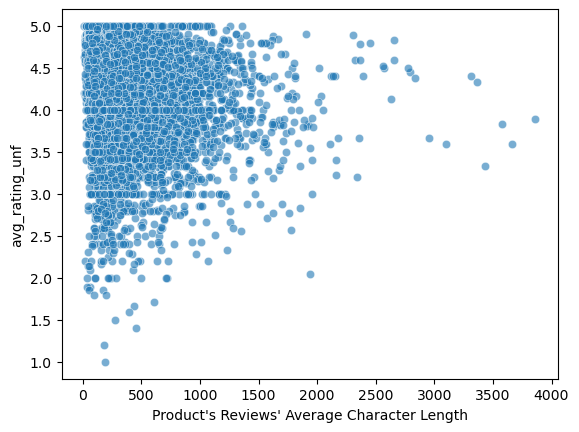

In [55]:
sns.scatterplot(data = df_iso_25.groupby('asin').mean(), x = 'Review_Ch_Len', y = 'avg_rating_unf', alpha = 0.6)
plt.xlabel('Product\'s Reviews\' Average Character Length');

In [56]:
df_iso_25.groupby('asin').mean().corr()

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores,Review_Ch_Len
overall,1.000000,-0.122230,0.094482,0.999937,0.565701,-0.475573,-0.298069,0.413724,-0.196665
vote,-0.122230,1.000000,0.001668,-0.122244,-0.137482,0.063746,0.180929,-0.187075,0.398017
count,0.094482,0.001668,1.000000,0.094523,0.014561,-0.015366,-0.029945,0.031025,0.006320
avg_rating_unf,0.999937,-0.122244,0.094523,1.000000,0.565603,-0.475265,-0.298279,0.413821,-0.196722
cmp_scores,0.565701,-0.137482,0.014561,0.565603,1.000000,-0.630402,-0.526161,0.687622,-0.279827
neg_scores,-0.475573,0.063746,-0.015366,-0.475265,-0.630402,1.000000,0.102687,-0.385825,0.191251
neu_scores,-0.298069,0.180929,-0.029945,-0.298279,-0.526161,0.102687,1.000000,-0.938676,0.389890
pos_scores,0.413724,-0.187075,0.031025,0.413821,0.687622,-0.385825,-0.938676,1.000000,-0.410350
Review_Ch_Len,-0.196665,0.398017,0.006320,-0.196722,-0.279827,0.191251,0.389890,-0.410350,1.000000


## Noticing Product's Sentiment Score not only reflects product quality, but also quickness of shipping

In [57]:
df_iso_25[df_iso_25['reviewText'].str.contains('ship')][['reviewText', 'avg_rating_unf']]

,reviewText,avg_rating_unf
19,1st shipment received a book instead of the ga...,3.181818
30,Installing the game was a struggle (because of...,3.181818
44,great set of guides. no shipping damage. all b...,4.812500
83,I have been looking forward to receiving this ...,4.812500
156,My son sayes he is still learning how to custo...,3.833333
...,...,...
320576,Item was as described\nFast shipping!,4.840000
320582,Great buy fast shipping,4.840000
320598,My daughter likes it. Fast shipping.,4.840000
320643,i love this game it fun playing this it was ni...,4.666667


In [58]:
# Proportion of reviews discussing shipping
df_iso_25[df_iso_25['reviewText'].str.contains('ship')][['reviewText', 'avg_rating_unf']].shape[0] / df_iso_25.shape[0]

0.02309899882526338

Not a really strict analysis, but it is clear that some product reviews not only reflect product quality, but the quickness of shipping. Fast shipping will increase the rating, but slow shipping will decrease the rating. 

## Do helpful reviews (reviews with nonzero helpfulness votes) have good correlation with the product's average rating? 

In [59]:
# Product Arrival also contributes to score, but does not really reflect product quality
# Rating is sum of arrival efficiency, quality, usability, 
temp = df_iso_25[df_iso_25['vote'] != 0]
display('Original Shape: ' + str(df_iso_25.shape))
display('New Shape: ' + str(temp.shape))
temp.head()

'Original Shape: (320923, 13)'

'New Shape: (36016, 13)'

,asin,overall,reviewText,summary,vote,count,avg_rating_unf,Sem_Scores,cmp_scores,neg_scores,neu_scores,pos_scores,Review_Ch_Len
15,0700099867,5.0,Loved playing Dirt 2 and I thought the graphic...,A step up from Dirt 2 and that is terrific!,11,22,3.181818,"{'neg_mean': 0.10300000000000001, 'neu_mean': ...",0.436475,0.103000,0.556000,0.340500,431
16,0700099867,4.0,I had Dirt 2 on Xbox 360 and it was an okay ga...,DIRT 3,2,22,3.181818,"{'neg_mean': 0.0645, 'neu_mean': 0.65450000000...",0.324017,0.064500,0.654500,0.281000,294
22,0700099867,1.0,DiRT 2 was like this. I'm becoming more & mor...,The first one was much better.,7,22,3.181818,"{'neg_mean': 0.12059259259259258, 'neu_mean': ...",-0.003444,0.120593,0.769741,0.109667,1652
30,0700099867,1.0,Installing the game was a struggle (because of...,Pay to unlock content? I don't think so.,9,22,3.181818,"{'neg_mean': 0.0887, 'neu_mean': 0.7654, 'pos_...",0.090880,0.088700,0.765400,0.145900,787
31,0700099867,3.0,"This is a pretty fun game, but you have to buy...",Fun,13,22,3.181818,"{'neg_mean': 0.08225, 'neu_mean': 0.82025, 'po...",0.157300,0.082250,0.820250,0.097500,743


In [60]:
# How many products have reviews with nonzero helpfulness; appears to be 9094 products;
# some products have drastically more reviews with nonzero helpfulness than others 
temp['asin'].value_counts()

B00178630A    288
B000ZKA0J6    120
B00KSQHX1K    104
B00ZQC73O8    101
B00ZQB28XK     86
             ... 
B001NTBWK4      1
B001NQB658      1
B001NPCTDC      1
B00HPU96FI      1
B0055UCIE6      1
Name: asin, Length: 9094, dtype: int64

In [61]:
# Seeing the text in a helpful review
temp.iloc[9]['reviewText']

"it was fun finding the differences in the pictures, but it got boring when the same pictures kept comming up. it would have been better NOT to have a time limit on these games.  that just makes it harder and frustrating for beginners like me.  i am handicapped and disabled and don't move that fast.  also i just turned 61, so i'm not that fast mentally either.  there should be an option to choose if you want it to be timed or not.  there should be that option on ALL games."

In [62]:
temp.corr()

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores,Review_Ch_Len
overall,1.000000,0.000183,-0.052556,0.381661,0.501339,-0.417091,-0.154914,0.389103,0.006654
vote,0.000183,1.000000,0.021472,-0.001272,-0.030621,-0.014658,0.075016,-0.062231,0.200063
count,-0.052556,0.021472,1.000000,0.097994,-0.052204,0.059733,-0.018076,-0.020191,0.025669
avg_rating_unf,0.381661,-0.001272,0.097994,1.000000,0.204522,-0.162601,-0.057300,0.145644,-0.015654
cmp_scores,0.501339,-0.030621,-0.052204,0.204522,1.000000,-0.647466,-0.321144,0.694273,-0.148549
neg_scores,-0.417091,-0.014658,0.059733,-0.162601,-0.647466,1.000000,-0.220478,-0.342512,0.032304
neu_scores,-0.154914,0.075016,-0.018076,-0.057300,-0.321144,-0.220478,1.000000,-0.798938,0.220994
pos_scores,0.389103,-0.062231,-0.020191,0.145644,0.694273,-0.342512,-0.798938,1.000000,-0.222328
Review_Ch_Len,0.006654,0.200063,0.025669,-0.015654,-0.148549,0.032304,0.220994,-0.222328,1.000000


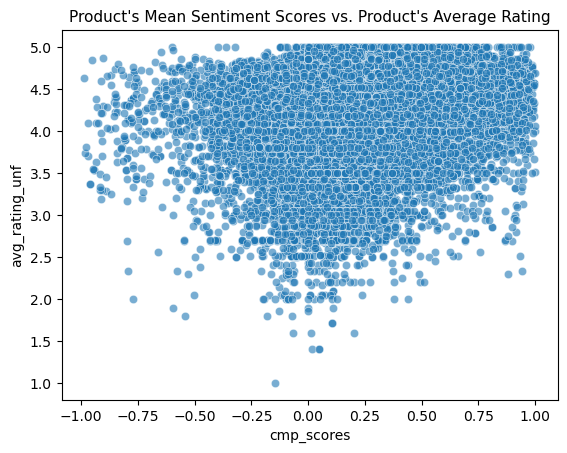

In [63]:
sns.scatterplot(data = temp, x ='cmp_scores', y = 'avg_rating_unf', alpha = 0.6)
plt.title('Product\'s Mean Sentiment Scores vs. Product\'s Average Rating', fontsize = 11); 

In [64]:
temp.groupby('asin').mean().corr()

,overall,vote,count,avg_rating_unf,cmp_scores,neg_scores,neu_scores,pos_scores,Review_Ch_Len
overall,1.000000,-0.018158,-0.037958,0.542925,0.497904,-0.411842,-0.194543,0.396587,-0.029343
vote,-0.018158,1.000000,0.065452,-0.023018,-0.058211,-0.015198,0.123219,-0.107336,0.222379
count,-0.037958,0.065452,1.000000,0.132574,-0.057731,0.061520,0.003973,-0.039110,0.040604
avg_rating_unf,0.542925,-0.023018,0.132574,1.000000,0.283320,-0.227822,-0.109269,0.214469,-0.024155
cmp_scores,0.497904,-0.058211,-0.057731,0.283320,1.000000,-0.643780,-0.385507,0.708571,-0.195454
neg_scores,-0.411842,-0.015198,0.061520,-0.227822,-0.643780,1.000000,-0.166490,-0.335126,0.093679
neu_scores,-0.194543,0.123219,0.003973,-0.109269,-0.385507,-0.166490,1.000000,-0.834840,0.233263
pos_scores,0.396587,-0.107336,-0.039110,0.214469,0.708571,-0.335126,-0.834840,1.000000,-0.262583
Review_Ch_Len,-0.029343,0.222379,0.040604,-0.024155,-0.195454,0.093679,0.233263,-0.262583,1.000000


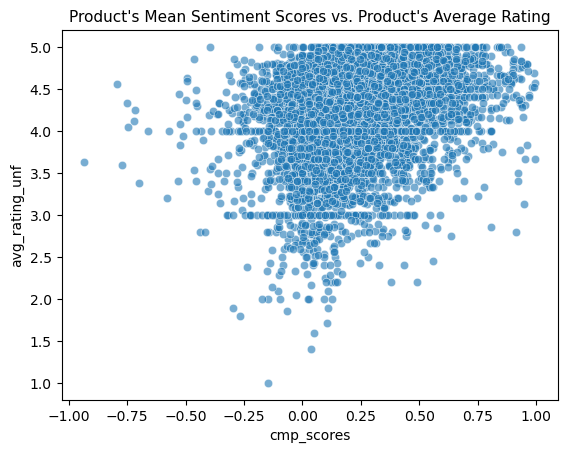

In [65]:
sns.scatterplot(data = temp.groupby('asin').mean(), x ='cmp_scores', y = 'avg_rating_unf', alpha = 0.6)
plt.title('Product\'s Mean Sentiment Scores vs. Product\'s Average Rating', fontsize = 11);

In [66]:
temp.shape[0] / df_iso_25.shape[0]

0.11222629727380089

After looking at the correlation of the mean average compound sentiment score from all reviews of a product with that product's average rating, it is clear from the correlation value of 0.28 that there is decent inherent variation in the mean sentiment scores for the reviews of each product to match the entire range of average product ratings. ***This sample is also 11% of the entire dataset, so it shows the size of the sample does not matter as much as the quality of the sample.*** 

**Future Work: Looking to see if there are some keywords in the helpful reviews that may be correlated with average rating**
1. Will probably start with creating an adjective frequency distribution amongst the helpful reviews

## Generate final matrix for linear regression model

In [67]:
final_data = (df_iso_25.groupby('asin').agg(np.mean)
              [['avg_rating_unf', 'cmp_scores', 'pos_scores', 'neg_scores','neu_scores', 'Review_Ch_Len']])
final_data

,avg_rating_unf,cmp_scores,pos_scores,neg_scores,neu_scores,Review_Ch_Len
asin,,,,,,
0700026398,3.200000,0.168953,0.289247,0.046769,0.663944,305.400000
0700026657,4.200000,0.464753,0.358039,0.038861,0.603167,242.000000
0700099867,3.181818,0.088304,0.211982,0.107430,0.674078,560.454545
0804161380,4.812500,0.460995,0.320402,0.023715,0.655866,413.791667
3828770193,4.200000,0.247624,0.281919,0.043267,0.674814,158.800000
...,...,...,...,...,...,...
B01HFRICLE,4.384615,0.224725,0.162128,0.040874,0.777774,312.000000
B01HGPUTCA,4.600000,0.215997,0.203962,0.081818,0.714220,825.800000
B01HH6JEOC,4.000000,0.263924,0.364452,0.026722,0.608790,268.857143


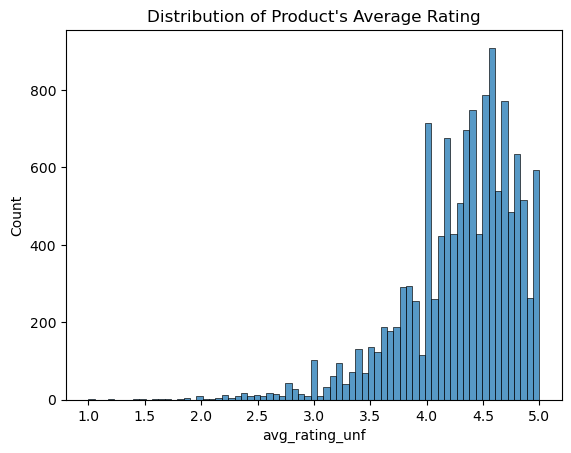

In [68]:
sns.histplot(data = final_data, x = 'avg_rating_unf');
plt.title('Distribution of Product\'s Average Rating');

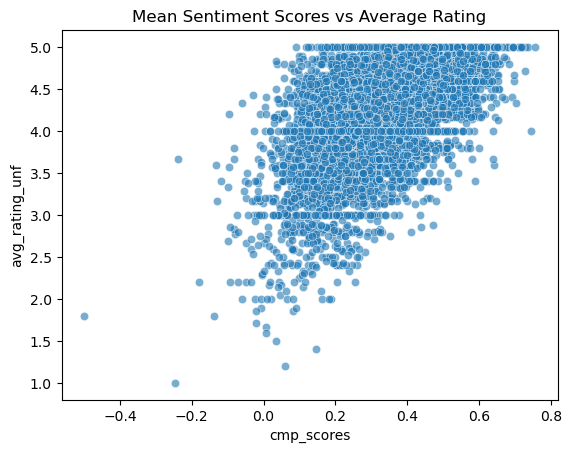

In [69]:
sns.scatterplot(data = final_data, x = 'cmp_scores', y = 'avg_rating_unf', alpha = 0.6);
plt.title('Mean Sentiment Scores vs Average Rating'); 

In [70]:
final_data.corr()

,avg_rating_unf,cmp_scores,pos_scores,neg_scores,neu_scores,Review_Ch_Len
avg_rating_unf,1.000000,0.565603,0.413821,-0.475265,-0.298279,-0.196722
cmp_scores,0.565603,1.000000,0.687622,-0.630402,-0.526161,-0.279827
pos_scores,0.413821,0.687622,1.000000,-0.385825,-0.938676,-0.410350
neg_scores,-0.475265,-0.630402,-0.385825,1.000000,0.102687,0.191251
neu_scores,-0.298279,-0.526161,-0.938676,0.102687,1.000000,0.389890
Review_Ch_Len,-0.196722,-0.279827,-0.410350,0.191251,0.389890,1.000000


## Linear Regression Model without Intercept

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = (train_test_split(
    final_data[['cmp_scores', 'neu_scores']], final_data['avg_rating_unf'], 
    test_size=0.20, random_state=42))

In [72]:
from sklearn import linear_model as lm
linear_model = lm.LinearRegression(fit_intercept= False)
linear_model.fit(X_train, y_train)
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

In [73]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(linear_model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
scores * -1

array([0.30183986, 0.30346264, 0.29137777, 0.30624705, 0.30532351])

In [74]:
from sklearn.metrics import mean_squared_error
display(mean_squared_error(y_train, y_train_pred))
display(mean_squared_error(y_test, y_test_pred))

0.3014687289110116

0.3040461216868561

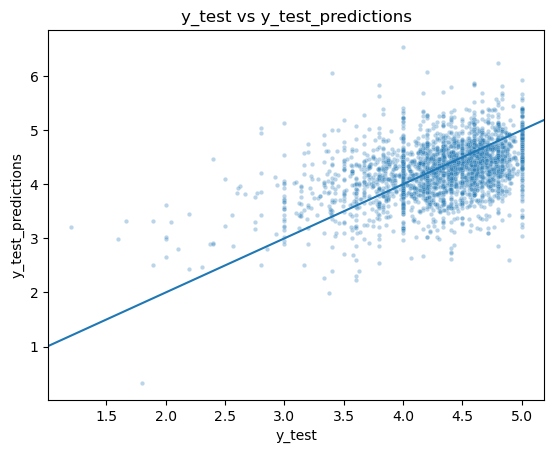

In [75]:
sns.scatterplot(x = y_test, y = y_test_pred, alpha = 0.3, s = 10)
plt.axline((2.5,2.5), slope = 1)
plt.xlabel('y_test')
plt.ylabel('y_test_predictions')
plt.title('y_test vs y_test_predictions');

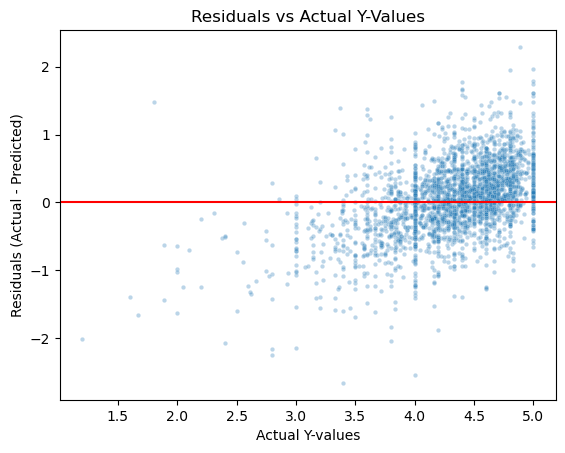

In [76]:
sns.scatterplot(y = y_test - y_test_pred, x = y_test, alpha = 0.3, s = 10)
plt.axhline(0, color = 'r')
plt.title('Residuals vs Actual Y-Values')
plt.xlabel('Actual Y-values')
plt.ylabel('Residuals (Actual - Predicted)');

### With Intercept

In [77]:
linear_model = lm.LinearRegression(fit_intercept= True)
linear_model.fit(X_train, y_train)
y_train_pred = linear_model.predict(X_train)
y_test_pred = linear_model.predict(X_test)

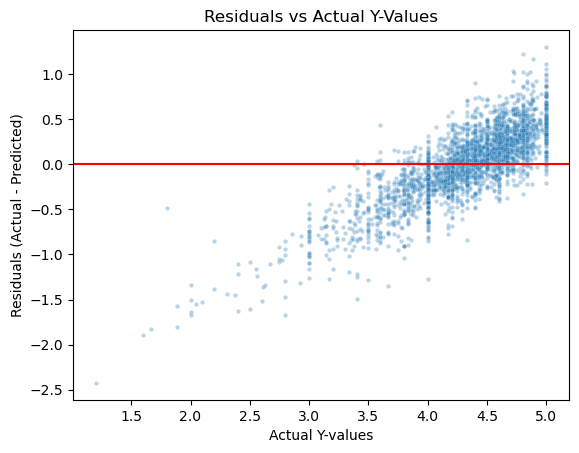

In [78]:
sns.scatterplot(y = y_test - y_test_pred, x = y_test, alpha = 0.3, s = 10)
plt.axhline(0, color = 'r')
plt.title('Residuals vs Actual Y-Values')
plt.xlabel('Actual Y-values')
plt.ylabel('Residuals (Actual - Predicted)');

## Modeling Thoughts:
1. Even though using no regularization, cross validation highlights that there isnt an inherent bias in training dataset since the cross validation mean squared error scores are consistent with the final training mean squared error value. 
2. Used neutral sentiment score as a predictor since although it was the second lowest in terms of magnitude of correlation with the product's average rating, it had the lowest correlation with compound sentiment score. Independence is greater in importance for improving model performance than largest correlation with target variable.
3. Did not end up using Average Review Character Length for each product as a predictor since it had little change (0.02) on the mean squared error and did not want to risk overfitting with no regularization being used. 


## Residual Plot Thoughts:
1. Seem to be consistently overpredicting average ratings less than 4.0 and for the most part, underpredicting ratings greater than 4.0
2. Removed intercept because it led to an extremely strong positively correlated pattern in the residual plot, highlighting regions of overpredicting for average rating less than 4 and underpredicting for average rating greater than 4.

## Discussion & Final Thoughts

1. Clearly, model is not perfect, but seems to be doing a good job in using the inherent relationship between the reviews' sentiment scores and the product's rating to make predictions on the average rating of the product.
2. Average product rating does not only reflect product quality, but also quickness in shipping
3. Should look into use of regularization to build a more robust model once I start adding more features. 
4. Need to see how and why the sample of only helpful reviews have good (with respect to other samples of the data) correlation with the product's average rating. 
> Potential Approach: Determine frequency distribution of adjectives used in helpful reviews and see the top few adjectives used to describe products. The next step would be to create a feature containing the average frequency of the use of these words in the reviews for a product. The assessment of the quality of this feature would be its correlation with the product's average rating. 

**Let me know thoughts on other features to potentially analyze or any issues in the analysis. This work was done entirely by Karthik Raj (SSID: 3035366972). Thank you for reading this report in its entirety!**